# Tensorflow solution

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


Load data from csv files.
Image is provided as space separated values in 'Image' column.

TODO:

  * Scala output labels into (-1, 1) range)

In [2]:
def make_image(xs):
    a = np.fromstring(xs, sep=' ', dtype=np.float).reshape(96, 96)
    return a / 256.0

df = pd.read_csv('../data/training.csv', converters={'Image': make_image})
df['Image'].head()

0    [[0.9296875, 0.921875, 0.92578125, 0.9296875, ...
1    [[0.85546875, 0.83984375, 0.796875, 0.765625, ...
2    [[0.5625, 0.5546875, 0.62109375, 0.703125, 0.7...
3    [[0.75390625, 0.75, 0.75390625, 0.7578125, 0.7...
4    [[0.57421875, 0.578125, 0.625, 0.765625, 0.839...
Name: Image, dtype: object

## Select only few labels

In [3]:
labels = ['nose_tip_x', 'nose_tip_y']
train = df[labels + ['Image']].dropna()
print('All images: %d, with labels: %d' % (len(df), len(train)))

All images: 7049, with labels: 7049


## Show image

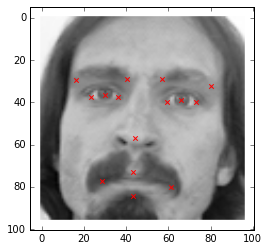

In [28]:
def show_image(row):
    plt.imshow(row.Image, cmap='Greys_r')
    xs = [row.left_eye_center_x, row.right_eye_center_x, row.left_eye_inner_corner_x, row.left_eye_outer_corner_x,
         row.right_eye_inner_corner_x, row.right_eye_outer_corner_x, row.left_eyebrow_inner_end_x, row.nose_tip_x,
         row.left_eyebrow_outer_end_x, row.right_eyebrow_inner_end_x, row.right_eyebrow_outer_end_x,
         row.mouth_left_corner_x, row.mouth_right_corner_x, row.mouth_center_top_lip_x, row.mouth_center_bottom_lip_x]
    ys = [row.left_eye_center_y, row.right_eye_center_y, row.left_eye_inner_corner_y, row.left_eye_outer_corner_y,
         row.right_eye_inner_corner_y, row.right_eye_outer_corner_y, row.left_eyebrow_inner_end_y, row.nose_tip_y,
         row.left_eyebrow_outer_end_y, row.right_eyebrow_inner_end_y, row.right_eyebrow_outer_end_y,
         row.mouth_left_corner_y, row.mouth_right_corner_y, row.mouth_center_top_lip_y, row.mouth_center_bottom_lip_y]
    plt.scatter(x=xs, y=ys, marker='x', color='red')
    
show_image(df.iloc[0])

## Build tensorflow model

### Evaluate score (RMSE)

In [29]:
def rmse(expected, predicted):
    p = tf.square(expected - predicted)
    ds = tf.reduce_mean(p, 1)
    return tf.reduce_mean(ds) #tf.sqrt(tf.reduce_mean(ds))

### Prepare training data

Convert images read by pandas into ndarray

In [33]:
VECTOR_SIZE = 96*96
X = np.concatenate(train['Image'].apply(lambda x: np.reshape(x, VECTOR_SIZE)))
X = np.reshape(X, (len(train), VECTOR_SIZE))
print(X.shape)
Y = train[labels].as_matrix() / 48.0 - 1
print(Y.shape)

(7049, 9216)
(7049, 2)


### Percepton

In [23]:
L1_COUNT = 100
# Create placeholders for image data and expected point positions
x_in = tf.placeholder(tf.float32, shape=[None, VECTOR_SIZE])
y_in = tf.placeholder(tf.float32, shape=[None, 2])

# Build neural network
def build_model(xs):
    W1 = tf.Variable(tf.truncated_normal([VECTOR_SIZE, L1_COUNT], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[L1_COUNT]))
    l1 = tf.nn.relu(tf.matmul(xs, W1) + b1)
    W2 = tf.Variable(tf.truncated_normal([L1_COUNT, 2], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[2]))
    return tf.matmul(l1, W2) + b2

# Define loss function
model = build_model(x_in)
loss = rmse(y_in, model)

MAX_ITER = 1000
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    for i in range(MAX_ITER):
        train_step.run(feed_dict={x_in: X, y_in: Y})
        if (i+1) % (MAX_ITER/10) == 0:
            score = loss.eval(feed_dict={x_in: X, y_in: Y})
            print('Epoch: %d, loss=%f' % (i+1, score))
    Y2 = model.eval(feed_dict={x_in: X})
Y2    

Epoch: 100, loss=0.126490
Epoch: 200, loss=0.127170
Epoch: 300, loss=0.126573
Epoch: 400, loss=0.127501
Epoch: 500, loss=0.126327
Epoch: 600, loss=0.129654
Epoch: 700, loss=0.127122
Epoch: 800, loss=0.127296
Epoch: 900, loss=0.127467
Epoch: 1000, loss=0.127141


array([[ 0.11038353,  0.25886321],
       [ 0.11038353,  0.25886321],
       [ 0.11038353,  0.25886321],
       ..., 
       [ 0.11038353,  0.25886321],
       [ 0.11038353,  0.25886321],
       [ 0.11038353,  0.25886321]], dtype=float32)

In [51]:
Y2.mean(0)

array([ 0.10616194,  0.25983542], dtype=float32)

Now when we have trained model, lets check where it thinks a nose is

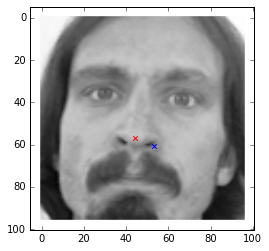

In [31]:
index = 0
a = (Y[index] + 1) * 48
b = (Y2[index] + 1) * 48
plt.imshow(np.reshape(X[index], (96, 96)), cmap='Greys_r')
plt.scatter(x=a[0], y=a[1], marker='x', color='r')
plt.scatter(x=b[0], y=b[1], marker='x', color='b')

## Remarks

It looks that this network will find average nose position and then stop learning.